### Circuit knitting as a method to improve performance of quantum circuits

<b>Ritajit Majumdar</b>
Quantum Enablement and Engineering Team @IBM Quantum

Circuit knitting is an umbrella term which encapsulates various methods of partitioning a circuit in multiple smaller subcircuits involving fewer gates and/or qubits. Each of the subcircuits can be executed independently and the final result is obtained via some classical postprocessing over the outcome of each subcircuit.

This notebook deals with a method called <b>wire cutting</b> where the circuit is partitioned along the wire [1,2]. Note that, partitioning is simple in classical circuits since the outcome at the point of partition can be determined deterministically, and is either 0 or 1. However, the state of the qubit at the point of the cut is, in general, a mixed state. Therefore, each subcircuit needs to be measured multiple times in different basis (usually a tomographically complete set of basis such as the Pauli basis [3,4]) and correspondingly prepared in its eigenstate. The Figure below (<i>courtesy: PhD Thesis, Ritajit Majumdar</i>) shows an example of wire cutting for a 4-qubit GHZ state into three subcircuits. Here $M_j$ denote a set of basis (usually Pauli X, Y and Z) and $P_i$ denote a set of eigenstates (usually $|0\rangle$, $|1\rangle$, $|+\rangle$ and $|+i\rangle$).

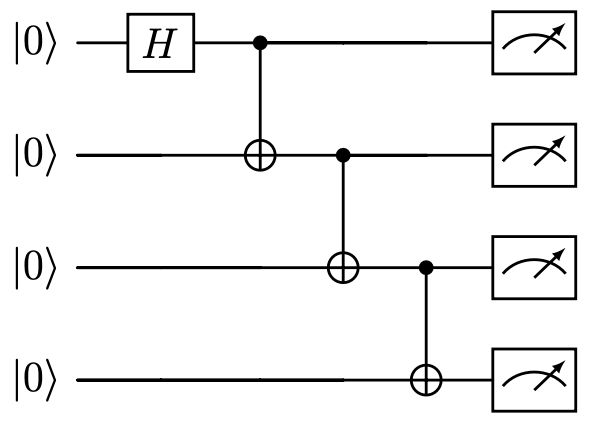
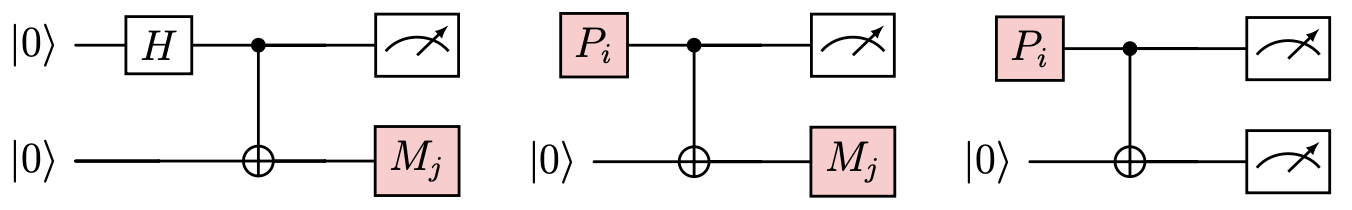

Since each subcircuit has fewer qubits and/or gates, they are expected to be less amenable to noise. This notebook shows an example where this method can be used to effectively suppress the noise in the system.

### Step 1: Map problem to quantum hardware native format

We shall take a **QAOA** [5] circuit as an example for this notebook. A QAOA is a variational algorithm where first a trial parameterized circuit, called **ansatz**, is prepared which is initialized, usually, with some random parameters. The circuit is then measured, and the expectation value of some observable is calculated. This entire process is called one *iteration*. This value is passed on to a classical optimizer, which predicts a new set of parameters such that the following iteration is expected to produce a better expectation value. This process is repeated till some convergence criteria is met.

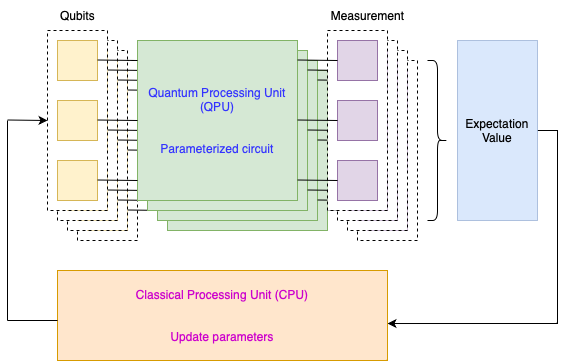

A QAOA circuit is characterized by two unitaries $U(H_P,\gamma)$ and $U(H_M,\beta)$, where $\gamma$ and $\beta$ are parameters. $H_P$ is the Hamltonian whose ground state is the solution of the problem at hand (e.g., vertex cover, max-cut etc.), and $H_M$ is some other Hamiltonian such that $[H_P,H_M] \neq 0$. A depth-p QAOA ansatz is mathematically expressed as:

<center>$|\gamma, \beta \rangle_p = U(H_M,\beta_p)U(H_P,\gamma_p) ... U(H_M,\beta_1)U(H_P,\gamma_1)|\psi_0 \rangle$</center>     

$|\psi_0 \rangle$ being some initial state, often an equal superposition state.

#### Build the QAOA circuit

Here we show the function to build a QAOA circuit. Initially we build a template circuit without any specific parameter values.

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

class QAOAPathCircuit(QuantumCircuit):
    """Parameterized QAOA acyclic line graph quantum circuit.

    The cost parameter-vector is labeled γ, and the mixer
    parameter-vector β. Overall, there will be one parameter per
    unit of two-qubit depth: half in γ and half in ß [1].
    Weights in the generating max-cut graph are all equal to one.

    Args:
        num_qubits: number of qubits (must be even).
        depth: two-qubit depth (must be even).
        barriers: if True adds barriers between layers.
        measurements: if True adds measurements at the end.

    Notes:
        [1] Farhi et.al. A Quantum Approximate Optimization Algorithm,
            https://arxiv.org/abs/1411.4028
    """

    def __init__(
        self, num_qubits: int, depth: int, *, barriers: bool = False, measurements: bool = False
    ) -> None:
        barriers = bool(barriers)
        measurements = bool(measurements)

        super().__init__(num_qubits, name=f"QAOAPathCircuit<{num_qubits}, {depth}>")

        gammas = ParameterVector("γ", depth // 2)
        betas = ParameterVector("β", depth // 2)

        self.h(range(num_qubits))
        for layer in range(depth // 2):
            if barriers:
                self.barrier()
            for qubit in range(0, num_qubits - 1, 2):
                self.rzz(gammas[layer], qubit, qubit + 1)
            for qubit in range(1, num_qubits - 1, 2):
                self.rzz(gammas[layer], qubit, qubit + 1)
            for qubit in range(num_qubits):
                self.rx(betas[layer], qubit)
        if measurements:
            self.measure_all()

We shall create a with 5 qubits p = 1 QAOA `reference-circuit` for the ease of demonstration of the different stages. For our actual experiment, we shall create a 70 qubits p = 1 QAOA `virtual-circuit` and show the results with and without cutting.

This circuit is amenable to cutting, and we shall see later than only a single wire cut is sufficient to partition this circuit into two disjoint subcircuits irrespective of the number of qubits.

Note that 2-qubit depth of the circuit is $2p$.

##### Reference circuit

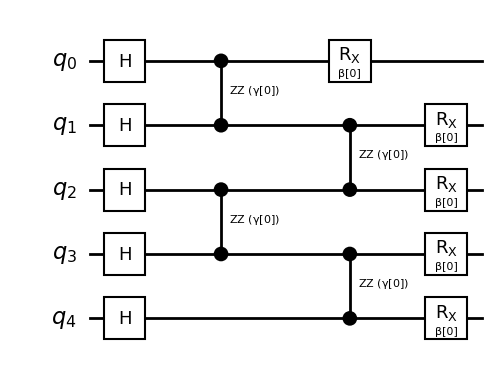

In [2]:
reference_num_qubits = 5
p = 1
reference_circuit = QAOAPathCircuit(num_qubits=reference_num_qubits, depth=2*p)
reference_circuit.draw('mpl', style='bw', fold=-1)

##### Virtual circuit

In [3]:
num_qubits = 70
p = 1
virtual_circuit = QAOAPathCircuit(num_qubits=num_qubits, depth=2*p)

### Step 2: Optimize circuits and operators

Next we cut the circuit into two smaller subcircuits. For this example, we stick to only 2 subcircuits. For this, we use the <a href="https://qiskit-extensions.github.io/circuit-knitting-toolbox/index.html">Circuit Knitting Toolbox</a> from Qiskit Ecosystem.

Before running this notebook, it is necessary to install the Circuit Knitting Toolbox. This can be done by executing ```pip install circuit_knitting_toolbox```

#### Cut the circuit into smaller subcircuits

We shall use the `automatic cut finder` from the Circuit-knitting-toolbox to find the location of the cut. This method finds the best cut location(s) to partition the circuit into disjoint pairs. The `best` cut location is selected according to the sampling overhead.

Using the automatic cut finder requires the circuit to be in the basis gate set of the backend. Therefore, we need to convert the circuit to basis gate set before we can use this technique. This can be perfomed by calling a transpilation pass manager, and passing the basis gate set of the backend.

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.get_backend('ibm_pinguino1')

We create the `preset-pass-manager` for transpilation.

In [5]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm_mapping = generate_preset_pass_manager(optimization_level=3, basis_gates=backend.basis_gates)

Now we transpile both the `reference-circuit` as well as the `virtual-circuit`. We shall draw the `transpiled-reference-circuit` for demonstration.

In [6]:
transpiled_reference_circuit = pm_mapping.run(reference_circuit)
transpiled_virtual_circuit = pm_mapping.run(virtual_circuit)

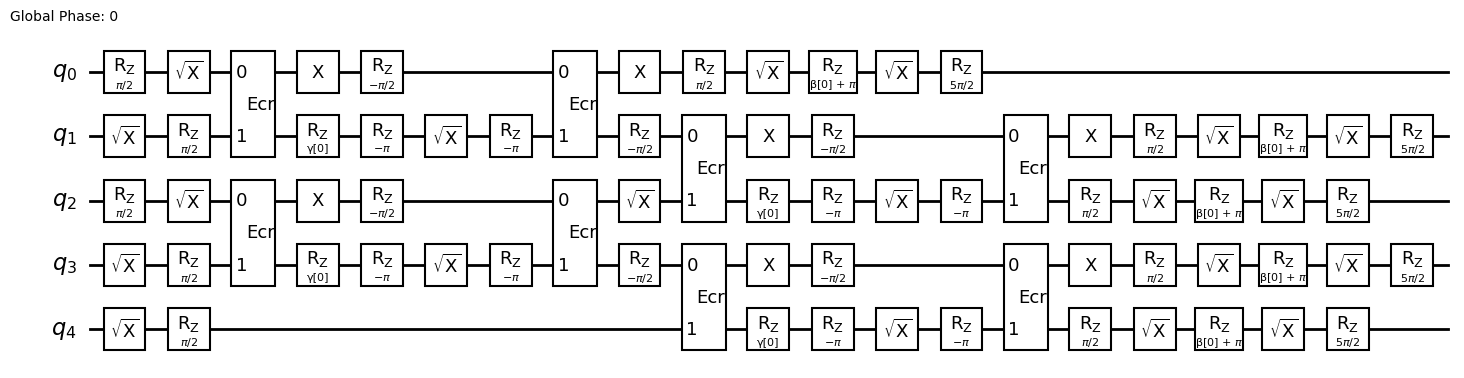

In [7]:
transpiled_reference_circuit.draw('mpl', style='bw', idle_wires=False)

Now we find the cut location using the automatic cut finder from Circuit-knitting-toolbox. We shall ask the automatic cut finder to provide us with a cut which produces subcircuits with roughly equal number of qubits.

In [8]:
from circuit_knitting.cutting.automated_cut_finding import (
    find_cuts,
    OptimizationParameters,
    DeviceConstraints,
)

optimization_settings = OptimizationParameters(seed=111)

##### Reference circuit

In [9]:
# Specify the size of the QPUs available
reference_device_constraints = DeviceConstraints(qubits_per_subcircuit=reference_num_qubits//2+1)

reference_cut_circuit, metadata = find_cuts(transpiled_reference_circuit, optimization_settings, reference_device_constraints)

Note the virtual 1-qubit gate `CutWire` annotated in the qubit $q_2$ of the `reference-cut-circuit`.

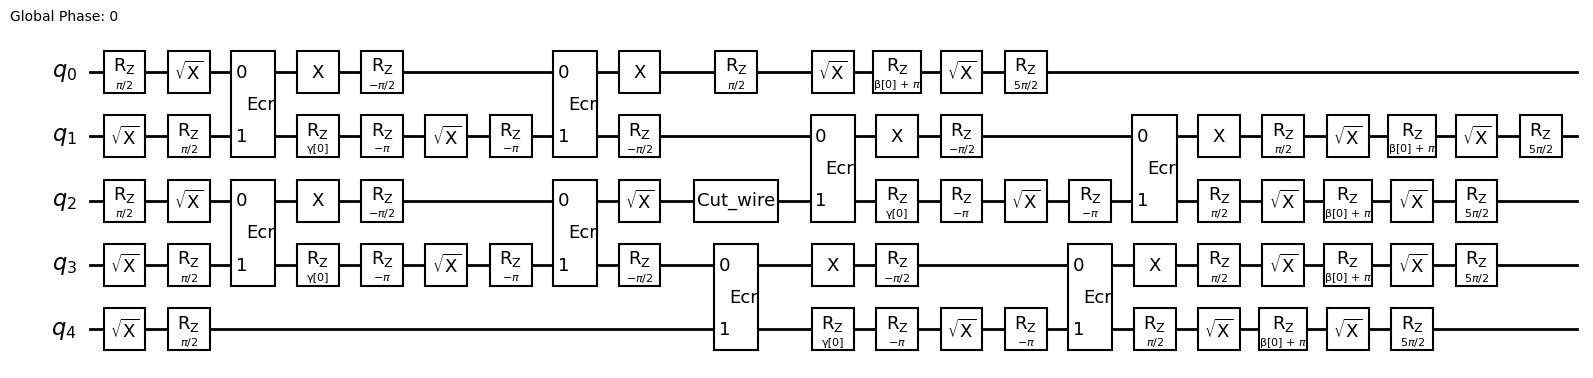

In [10]:
reference_cut_circuit.draw("mpl", style='bw', idle_wires=False)

##### Virtual circuit

In [11]:
device_constraints = DeviceConstraints(qubits_per_subcircuit=num_qubits//2+1)

cut_circuit, metadata = find_cuts(transpiled_virtual_circuit, optimization_settings, device_constraints)

We can verify that even for the 70 qubit circuit only a single wire cut is required. For this, we display the operators used in the circuit and note that only a single `cut-wire` is present.

In [12]:
cut_circuit.count_ops()

OrderedDict([('rz', 590),
             ('sx', 313),
             ('ecr', 138),
             ('x', 104),
             ('cut_wire', 1)])

Cutting the wire at a point increases the qubit count by one. Apart from the original qubit, there is now an extra qubit as a placeholder to the circuit after cutting. The following image gives a representation:

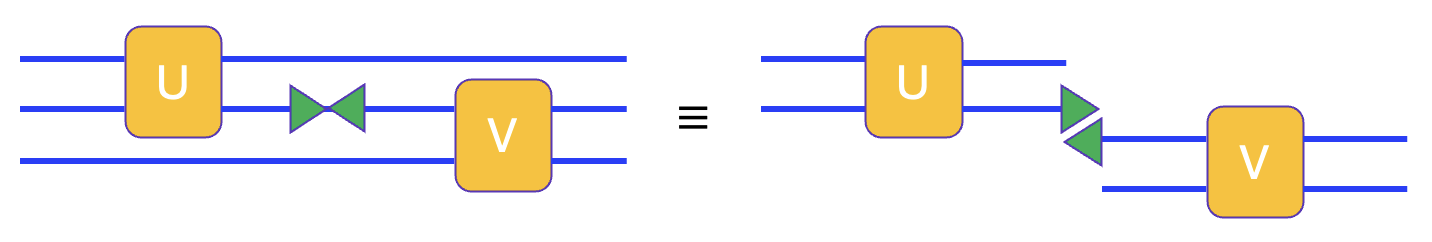

Circuit-knitting toolbox takes care of this increase in number of qubit due to cutting by the `cut-wires` function. Note that this function is different from the `cut-wire` virtual gate, although the names are very similar. The former is a function to account for the overall increase in the number of qubits due to cutting, while the later is an annotation for the cut location.

In [13]:
from circuit_knitting.cutting import cut_wires

reference_move_circuit = cut_wires(reference_cut_circuit)
virtual_move_circuit = cut_wires(cut_circuit)

#### Create and expand the observables

Now we create the observable for the problem. Since we have considered a QAOA circuit, we shall use the observable corresponding to the Max-Cut problem: $\sum_{(i,j)\in E} Z_i Z_j$. Note that the lower the value of this observable, the better is the result. Moreover, from the variational principle, the outcome can never to lower than the global minima. This allows us to compare the performance of this algorithm with and without circuit cutting, even without knowing the exact result.

Here, we first create the $Z_i Z_j$ observables for each edge.

In [14]:
from qiskit.quantum_info import SparsePauliOp

reference_observable = SparsePauliOp(['I'*i + 'ZZ' + 'I'*(reference_num_qubits-i-2) for i in range(reference_num_qubits-1)])
observable = SparsePauliOp(['I'*i + 'ZZ' + 'I'*(num_qubits-i-2) for i in range(num_qubits-1)])

Note that, as discussed before, the number of qubits increase after the partitioning of the circuit. Therefore, we need to expand the observables as well by inserting identitites to account for this.

In [15]:
from circuit_knitting.cutting import expand_observables

expanded_reference_observable = expand_observables(reference_observable.paulis, reference_cut_circuit, reference_move_circuit)
expanded_observable = expand_observables(observable.paulis, cut_circuit, virtual_move_circuit)

Now we shall partition the circuit into two subcircuits

In [16]:
from circuit_knitting.cutting import (
    partition_problem,
    generate_cutting_experiments,
    reconstruct_expectation_values,
)

reference_partition_problem = partition_problem(circuit=reference_move_circuit, observables=expanded_reference_observable)
partitioned_problem = partition_problem(circuit=virtual_move_circuit, observables=expanded_observable)

Let us visualize the subcircuits and the subobservables for the reference_circuit

In [17]:
reference_subcircuits = reference_partition_problem.subcircuits
reference_subobservables = reference_partition_problem.subobservables

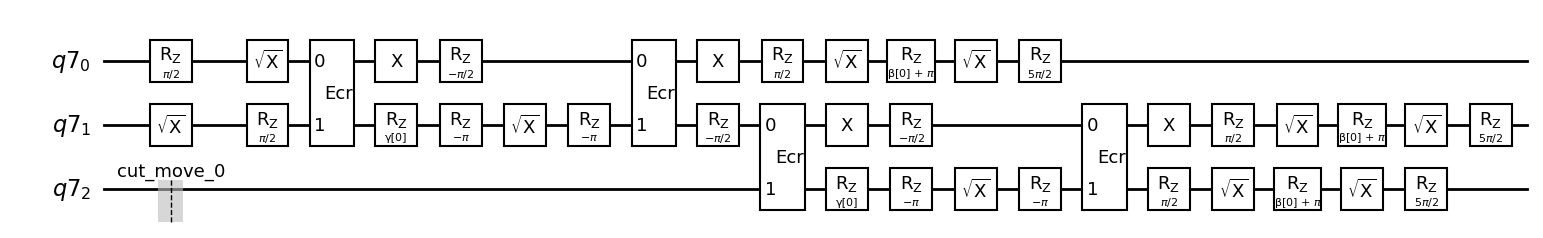

In [18]:
reference_subcircuits[0].draw('mpl', style='bw', fold=-1)

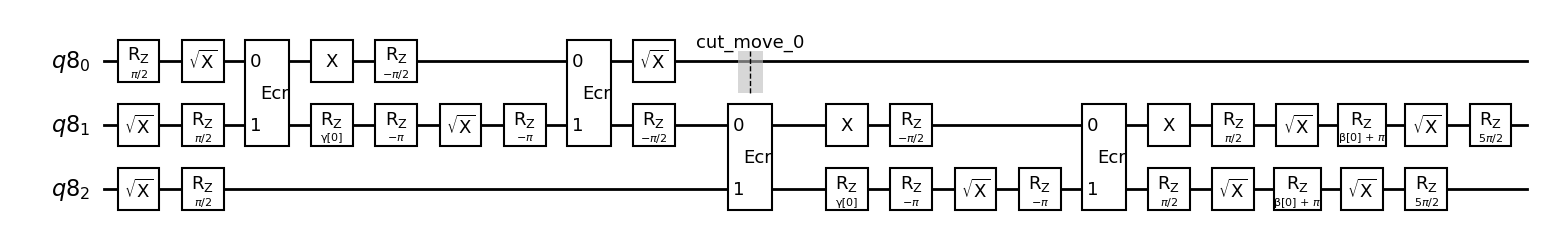

In [19]:
reference_subcircuits[1].draw('mpl', style='bw', fold=-1)

In [20]:
reference_subobservables

{0: PauliList(['III', 'ZII', 'ZZI', 'IZZ']),
 1: PauliList(['ZZI', 'IZI', 'III', 'III'])}

We also create the subcircuits and subobservables for the 70 qubit example.

In [21]:
subcircuits = partitioned_problem.subcircuits
subobservables = partitioned_problem.subobservables

### Step 3: Execute using a Qiskit primitive

Since now we have used the `reference_circuit` for the ease of visualization. However, from now on we shall use only the 70-qubit example for execution and generation of result.

Note that each subcircuit leads to a number of samples. The reconstruction takes into account the outcome of each of these samples. Each of these samples is termed a *subexperiment* in Circuit-knitting-toolbox.

#### Obtain the subexperiments

In [22]:
import numpy as np

subexperiments, coefficients = generate_cutting_experiments(
    circuits=subcircuits,
    observables=subobservables,
    num_samples=np.inf
)

In [23]:
subexperiments

{0: [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f918af86e90>,
 1: [<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f918afa3b80>,
  <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f918b058820>]}

#### Transpile each subexperiment

Previously we converted each subexperiment to the basis gate set of the backend. Now we need to traspile our circuits to make it isomorphic to the backend before submitting them for execution. Therefore, we shall transpile each circuit in the subexperiments first.

In [24]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

In [25]:
subexperiments_trans = {}

for key, subckt in subexperiments.items():
    subexperiments_trans[key] = pm.run(subckt)

Since the circuit is transpiled, it is necessary for the observable to conform to the layout of the transpiled circuit. This can be obtained by applying the layout to the observable.

#### Run the optimization

Recall that we aim to find the expectation value of the observable $\sum_{(i,j) \in edge}Z_i Z_j$. This expectation value is proportional to the Max-Cut value of the QAOA upto some constant terms [5]. The lower is the value, the better it is.

We initialize the initial set of parameters to some random value.

Note that due to the iterative method of QAOA, the run and postprocess steps are shown together. For each step, the circuit is executed, and the postprocessing step (i) calculates the expectation value for the observable, and in case of cutting (ii) merges the outcomes of different subcircuits.

In [26]:
from numpy.random import default_rng
from numpy import pi

rng = default_rng(seed=0)

gamma = rng.uniform(-pi, pi, size=p).tolist()
beta = rng.uniform(-pi, pi, size=p).tolist()

print("PARAMETERS:")
print(f"γ:= {gamma}")
print(f"β:= {beta}")

PARAMETERS:
γ:= [0.8605556614246863]
β:= [-1.4464727375963786]


In [27]:
init_params = []

for i in range(p):
    init_params.append(gamma[i])
    init_params.append(beta[i])

Note that for each layer of QAOA there are two parameters. Therefore, each cut subcircuit also has two parameters. This makes the parameter assignment simpler. However, for more general problems, it is necessary to keep track of which parameter goes to which subcircuit, so that the assignment is proper.

In [28]:
def calculate_cut_expval(params: list, subexperiments: dict, coefficients: list, subobservables: dict, sampler) -> float:
    # assign parameters
    circuits = {}
    for key, ckt_list in subexperiments.items():
        circuits[key] = []
        for ckt in ckt_list:
            circuits[key].append(ckt.assign_parameters(params))

    # execute the circuits
    results = {
        label: sampler.run(subexp).result()
        for label, subexp in circuits.items()
    }

    # reconstruct and calculate expectation values
    reconstructed_expvals = reconstruct_expectation_values(
        results,
        coefficients,
        subobservables,
    )

    # return the sum of the expectation values
    return sum(reconstructed_expvals)

First, we remove any error mitigation and suppression from the Sampler primitive. This ensures that any improvement obtained via this method is solely because of cutting.

Furthermore, often the optimization may run for hundreds of steps. For this example, we prematuredly stop the optimization after 5 steps. But we invite the users to run the optimization step till convergence.

In [29]:
from scipy.optimize import minimize
from qiskit_ibm_runtime import Batch, SamplerV2

with Batch(backend=backend) as batch:
    sampler = SamplerV2(session=batch)
    sampler.options.default_shots = 10000
    sampler.options.dynamical_decoupling.enable = False
    sampler.options.twirling.enable_gates = False
    sampler.options.twirling.enable_measure = False

    res_cut = minimize(
        calculate_cut_expval, init_params, args=(subexperiments_trans, coefficients, subobservables, sampler), method="cobyla", options={'maxiter':10}
    )

In [30]:
res_cut

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -31.504420139994767
       x: [ 7.793e-01 -6.829e-01]
    nfev: 10
   maxcv: 0.0

### Step 4: Postprocess and analyze results

#### Cross verify

Let us now run the same QAOA without circuit cutting, keeping other parameters and variables same.

First we need to transpile the uncut circuit, and apply the layout of the transpile circuit to the observable.

In [28]:
isa_circuit = pm.run(virtual_circuit)

In [29]:
isa_observable = observable.apply_layout(isa_circuit.layout, num_qubits=backend.num_qubits)

In [30]:
def calculate_uncut_expval(params: list, circ: QuantumCircuit, observable: SparsePauliOp, estimator) -> float:
    result = estimator.run([(circ, observable, params)]).result()[0]
    expval = result.data.evs

    return expval

Previously we used Sampler since Circuit-knitting-toolbox uses this primitive. However, for the uncut circuit, we resort to using the Estimator primitive since it is the most natural choice for calculating expectation values. As before, we shall disable all error suppression and mitigation techniques for this experiment.

In [33]:
from qiskit_ibm_runtime import EstimatorV2

In [35]:
with Batch(backend=backend) as batch:
    estimator = EstimatorV2(session=batch)
    estimator.options.default_shots = 10000
    estimator.options.dynamical_decoupling.enable = False
    estimator.options.twirling.enable_gates = False
    estimator.options.twirling.enable_measure = False
    estimator.options.resilience_level = 0
    estimator.options.resilience.measure_mitigation = False

    res_uncut = minimize(
        calculate_uncut_expval, init_params, args=(isa_circuit, isa_observable, estimator), method="cobyla", options={'maxiter':10}
    )

In [36]:
res_uncut

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -23.574399999999994
       x: [ 6.964e-01 -7.215e-01]
    nfev: 10
   maxcv: 0.0

#### Inference

Recall that the observable was selected from the Max-Cut problem, and lower the value of the objective function, the better it is. We observe that after 10 steps of iteration, the cut QAOA reached an objective function which is significantly lower than that of the uncut QAOA. This shows that cutting alone can suppress the effect of noise by lowering the number of qubits and/or gates. It is possible to achieve even further improvement by enabling the different error suppression and mitigation techniques available in Qiskit Runtime

Note that it is possible to use other error suppression and mitigation methods together with circuit cutting to further improve the performance. Moreover, in this notebook, we computed both the subcircuits on the same hardware. In [6,7], the authors shows a method to distribute the subcircuits on different hardware using noise information in order to maximize the noise suppression, and parallelize the process.

### Word of caution

The number of circuits to be executed increases with the number of cuts. Therefore, while many cuts can produce small subcircuits, thus further improving the performance, it also leads to a significantly high number of circuit executions, which may not be practical for most cases. Below, we show an example of the number of subcircuits corresponding to the number of cuts for a 50-qubit circuit.

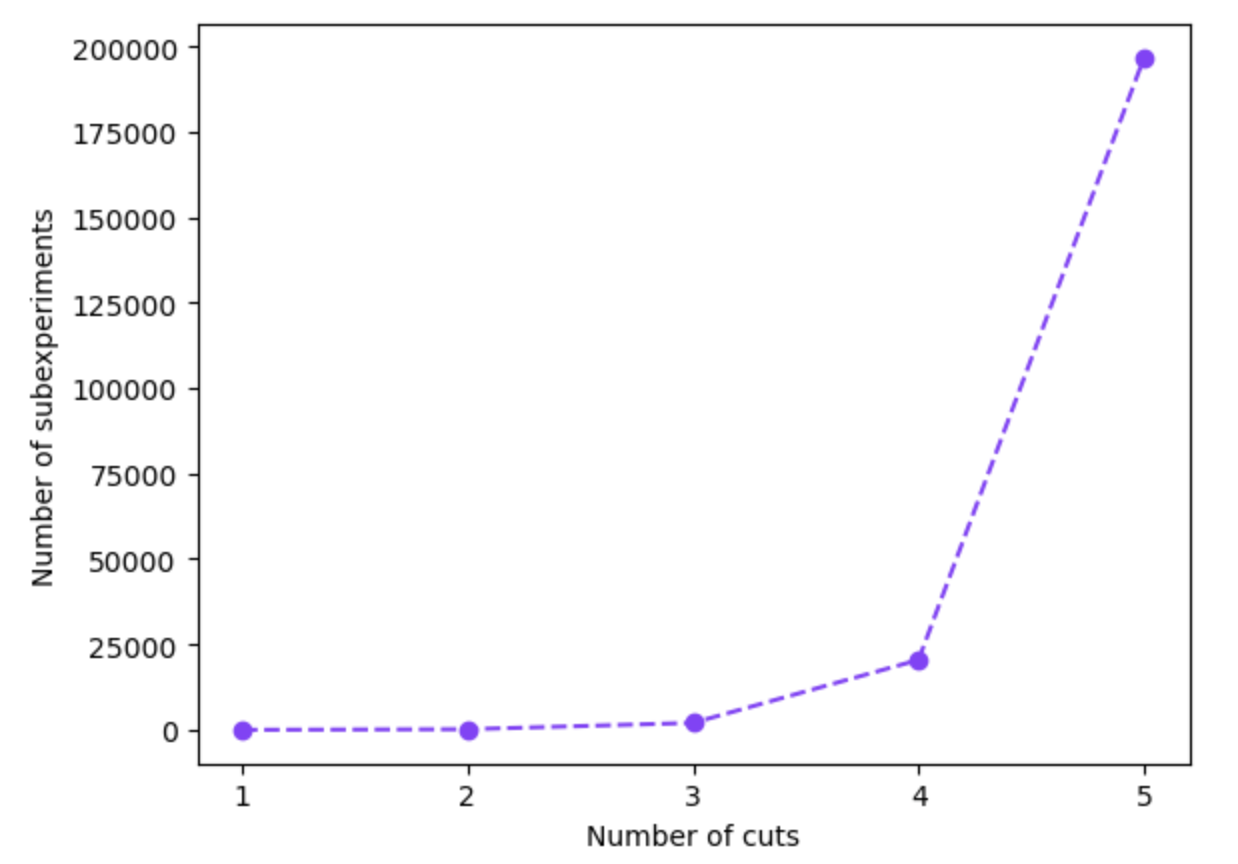

We note that even for 5 cuts the number of subexperiments is around 200k. Therefore, circuit cutting should be used only when the number of cuts is small.

### One example of cut-friendly and cut-unfriendly circuits each

#### Cut-friendly circuit

As noted earlier, a circuit is cut-friendly when the circuit can be partitioned into smaller disjoint subcircuits with a small number of cuts. Any hardware-efficient circuit, i.e., a circuit which requires little to no SWAP gates when mapped to the hardware coupling map, is, in general, cut-friendly. Below, we show an example of an excitation preserving ansatz, which is used in Quantum Chemistry. Note that such a circuit can be partitioned into two subcircuits with a single cut irrespective of the number of qubits. The cut location for the following example is shown as a cross within the circuit.

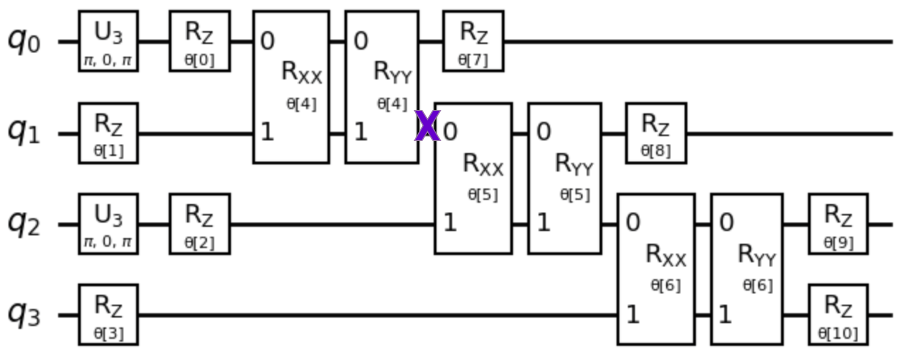

#### Cut-unfriendly circuit

A circuit is cut-unfriendly if, in general, the number of cuts required to form disjoint partitions grow significantly with the depth of the number of qubits. Recall that with each cut an extra qubit is required. So with the number of cuts, the effective number of qubits also increase. Below we show an example of a 3-qubit Grover circuit with a possible cutting instance.

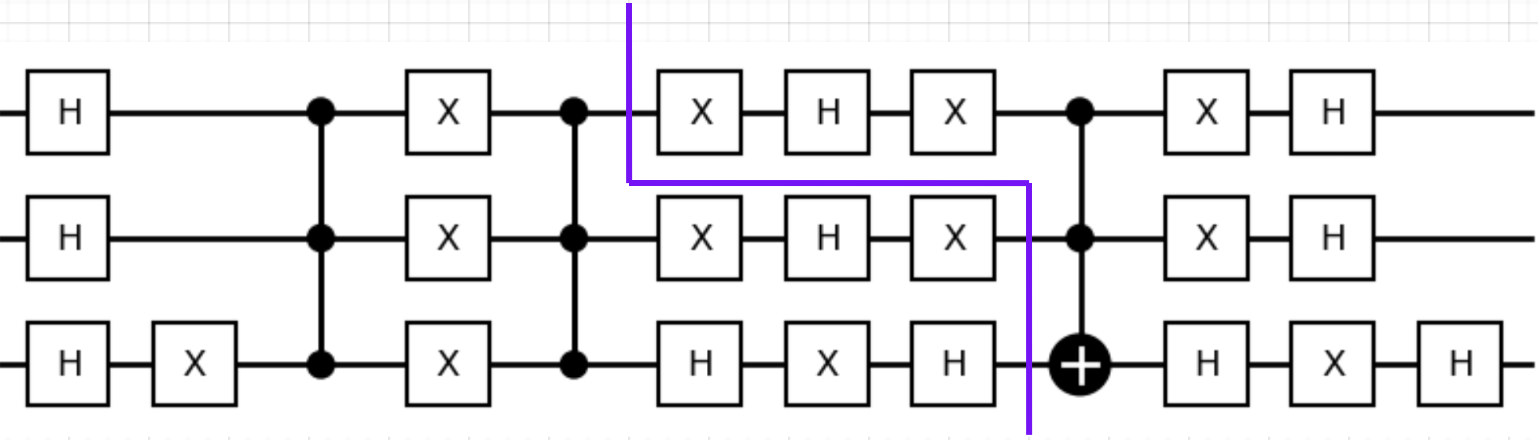

We note that three cuts are required, and the cut is more vertical than horizontal. This means, that the number of cuts is expected to scale linearly with the number of qubits, which is not amenable for cutting.

<b>References</b>

<ol>
  <li>Peng, T., Harrow, A. W., Ozols, M., & Wu, X. (2020). Simulating large quantum circuits on a small quantum computer. Physical review letters, 125(15), 150504.</li>
  <li>Tang, W., Tomesh, T., Suchara, M., Larson, J., & Martonosi, M. (2021, April). Cutqc: using small quantum computers for large quantum circuit evaluations. In Proceedings of the 26th ACM International conference on architectural support for programming languages and operating systems (pp. 473-486).</li>
  <li>Perlin, M. A., Saleem, Z. H., Suchara, M., & Osborn, J. C. (2021). Quantum circuit cutting with maximum-likelihood tomography. npj Quantum Information, 7(1), 64.</li>
  <li>Majumdar, R., & Wood, C. J. (2022). Error mitigated quantum circuit cutting. arXiv preprint arXiv:2211.13431.</li>
  <li>Farhi, E., Goldstone, J., & Gutmann, S. (2014). A quantum approximate optimization algorithm. arXiv preprint arXiv:1411.4028.</li>
  <li>Khare, T., Majumdar, R., Sangle, R., Ray, A., Seshadri, P. V., & Simmhan, Y. (2023). Parallelizing Quantum-Classical Workloads: Profiling the Impact of Splitting Techniques. In 2023 IEEE International Conference on Quantum Computing and Engineering (QCE) (Vol. 1, pp. 990-1000). IEEE.</li>
  <li>Bhoumik, D., Majumdar, R., Saha, A., & Sur-Kolay, S. (2023). Distributed Scheduling of Quantum Circuits with Noise and Time Optimization. arXiv preprint arXiv:2309.06005.</li>
</ol>

In [39]:
import qiskit_ibm_runtime
import qiskit
from importlib.metadata import version

print(f"qiskit runtime version {qiskit_ibm_runtime.version.get_version_info()}")
print(f"qiskit version {qiskit.version.get_version_info()}")
print(f"circuit-knitting-toolbox version {version('circuit-knitting-toolbox')}")

qiskit runtime version 0.23.0
qiskit version 1.0.2
circuit-knitting-toolbox version 0.7.1
